### Importing all the relevant libraries

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pkg_resources
import pandas as pd
import numpy as np
import sobol_seq
from tabulate import tabulate
import time
import types

In [2]:
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tabulate==0.8.3
pandas==0.24.2
numpy==1.16.3
matplotlib==3.0.3


### Define a function to uniform the database formatting as to ease their cross-comparison

In [3]:
def formatting(x):
    return pd.pivot_table(pd.melt(x,id_vars=['ProgrammingPeriod','Country','NUTS1Code','NUTS2Code','Year'],
        var_name='FundingScheme'),index=['ProgrammingPeriod','FundingScheme','Country','NUTS1Code','NUTS2Code'],
        values='value',columns='Year')

### Open the dataset and isolate the rows relative to DG REGIO programmes

In [4]:
df = pd.read_excel('nuts_prog_kat_Cohesion_codesonly_v3.xlsx',usecols=[0,1,5,6,9,10,11,12])

df_EU = pd.read_excel('Database_Final_UPD(3).xlsx')
df_REGIO = df[(df['CCI'].str.contains("161"))|df['CCI'].str.contains("162")]
df_expenditures = pd.read_excel('PivotedData.xlsx',sheet_name='Mean',index_col=0)

### Let us normalise the database as to make figures consistent between the Czech and the EU datasets

In [5]:
df_REGIO_capped = df_REGIO[df_REGIO.year<2017]

### Assumption on the exchange rate - retrieved from http://sdw.ecb.europa.eu

In [6]:
ER = pd.read_csv('CZK_EURO_historical_exchange_rate.csv')
ExchangeRates = ER.copy()
ExchangeRates['year']=ER.date.astype(str).str[:4].astype(int)
ExchangeRates = ExchangeRates[(ExchangeRates['year']>2006)&(ExchangeRates['year']<2017)]
ExchangeRates=ExchangeRates.drop(['date','conf'],axis=1).set_index('year')

### Let adjust the database formatting for the sake of comparability across figures

In [7]:
DS = [df_EU,df_expenditures]
ds_names = ['EU_Payments','Expenditures']
ds_pivoted = dict(zip(ds_names,[formatting(ds) for ds in DS]))

### Let isolate the IT figures for the programming period 2007-2013, the funding scheme ERDF

In [8]:
ds_ERDF = ds_pivoted['Expenditures'].loc['2007-2013','ERDF_TOTAL','CZ',:,:]
ds_ERDF.index = ds_ERDF.index.droplevel(1)
ds_CF = ds_pivoted['Expenditures'].loc['2007-2013','CF_TOTAL','CZ',:,:]
ds_CF.index = ds_CF.index.droplevel(1)
df_20072013_CFERDF_CZ=(ds_ERDF+ds_CF).T.loc[2007:].T

In [9]:
df_REGIO_yearly = df_REGIO_capped.groupby('year')
df_REGIO_su = pd.DataFrame([dfr['EU (czk)'].sum() for idf, dfr in df_REGIO_yearly], 
                            index=[idf for idf, dfr in df_REGIO_yearly],columns=['sum'])

In [10]:
ExchangeRates['s2'] = ExchangeRates.s1.mean()

In [11]:
exchange_rate = [ExchangeRates.s1,ExchangeRates['s2']]
er_n = ['Constant','Yearly average']

In [12]:
Excess=(df_REGIO_capped.groupby('NUTS2').sum())['EU (czk)']-df_20072013_CFERDF_CZ.groupby('NUTS2Code').sum().sum(axis=1)

Excess

NUTS2
CZ01    3.843249e+10
CZ02    7.417647e+10
CZ03    7.228067e+10
CZ04    5.887084e+10
CZ05    6.846363e+10
CZ06    9.250550e+10
CZ07    6.994598e+10
CZ08    6.954484e+10
dtype: float64

In [13]:
df_REGIO_yearly = df_REGIO_capped.groupby(['NUTS2','year']).sum()
df_REGIO_yearly['Year']=df_REGIO_yearly.index.get_level_values(1)
df_REGIO_yearly=df_REGIO_yearly.droplevel(1)
df_REGIO_pv = df_REGIO_yearly.pivot_table(index='Year', columns='NUTS2', values='EU (czk)').fillna(0)

### Let us test how the assumption on the number of years from which the exceeding payment should be cut out for the sake of normalisation

In [14]:
distance_l = []
distance_y = []
norm = []
idx = []
for ei,i in enumerate(reversed(df_REGIO_pv.index)):
    for ie,er in enumerate(exchange_rate):
        df_REGIO_sum = (df_REGIO_pv.T/er.values).T
        Excess = df_REGIO_sum.sum()-df_20072013_CFERDF_CZ.groupby('NUTS2Code').sum().sum(axis=1)
        df_REGIO_norm = df_REGIO_sum.copy()
        df_REGIO_norm.loc[i:2016]=df_REGIO_sum.loc[i:2016]-Excess/(2016-i+1)
        norm.append(df_REGIO_norm)
        distance_l.append((np.abs((df_REGIO_norm.cumsum()-df_20072013_CFERDF_CZ.droplevel([0,1,2]).T.loc[2007:].cumsum())/\
                       df_REGIO_norm.sum())).sum().round(1))
        distance_l[-1]['years']=ei+1
        distance_l[-1]['exchange_rate']=er_n[ie]
        distance_y.append(np.abs(df_REGIO_norm.cumsum()-df_20072013_CFERDF_CZ.droplevel([0,1,2]).T.loc[2007:].cumsum()))
        distance_y[-1]['years']=ei+1
        norm[-1]['years']=ei+1
        distance_y[-1]['exchange_rate']=er_n[ie]
distance = pd.concat(distance_l,axis=1).T.set_index(['years', 'exchange_rate']).sort_index(by=['exchange_rate','years'])
distance_yearly = pd.concat(distance_y).sort_index()
distance_yearly.set_index(['exchange_rate','years'],append=True, inplace=True)
distance_yearly=distance_yearly.reorder_levels([1,2,0]).sort_index(by=['exchange_rate','years','Year'])
norm_df = pd.concat(norm).sort_index()
norm_df.set_index('years',append=True, inplace=True)
norm_df=norm_df.swaplevel().sort_index(by=['years','Year'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)


In [15]:
norm_data = norm_df.groupby('Year').min()
norm_data['val']='min'
norm_data.set_index('val',append=True, inplace=True)
norm_data=norm_data.swaplevel().sort_index(by=['val','Year'])
norm_data2 = norm_df.groupby('Year').max()
norm_data2['val']='max'
norm_data2.set_index('val',append=True, inplace=True)
norm_data2=norm_data2.swaplevel().sort_index(by=['val','Year'])
norm_dataset = pd.concat([norm_data,norm_data2]).to_csv('norm_CZ_NUTS2.csv',header=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  


In [232]:
mu = pd.read_csv('mu_CZ.csv',index_col=0)

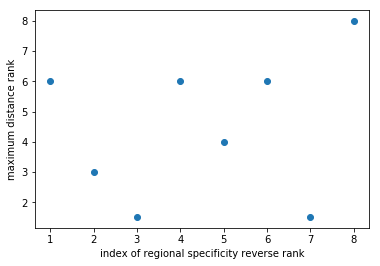

In [233]:
plt.scatter(mu.rank(ascending=False),distance.max().rank(),label=distance.max().index)
plt.xlabel('index of regional specificity reverse rank')
plt.ylabel('maximum distance rank')
plt.show()

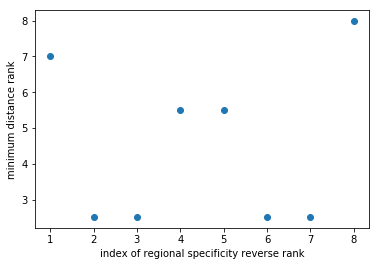

In [234]:
plt.scatter(mu.rank(ascending=False),distance.min().rank(),label=distance.max().index)
plt.xlabel('index of regional specificity reverse rank')
plt.ylabel('minimum distance rank')
plt.show()